In [0]:
# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g= 9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
    def initializations(self):
        
        #Defining A Matrix
        A = np.zeros((4,4))
        A[0,0] = 1 
        A[0,2] = self.dt
        A[1,1] =1
        A[1,3] = self.dt
        A[2,1] = (self.dt*self.mp*self.g)/self.mc
        A[2,2] = 1
        A[3,1] = (self.dt*(self.mc + self.mp)*self.g)/(self.l*self.mc)
        A[3,3] = 1
        
        #Defining B Matrix
        B = np.zeros((4,1))
        B[2,0] = self.dt/self.mc
        B[3,0] = self.dt/(self.l*self.mc)
        
        #Defining Q Matrix
        Q = np.zeros((4,4))
        Q[0,0] = 1
        Q[1,1] = 1
        Q[2,2] = 1
        Q[3,3] = 1
        
        #Defining R Matrix
        R = np.zeros((1,1))
        R[0,0] = 1
        
        #Constant K Matrix definition
        K = np.array([9.53146, -220.97185,   20.19384,  -67.99139])
        
        K = K
        #Constant P Matrix definition
        P = np.zeros((4,4))
        P[0,0] = 1.
        P[0,1] = 0
        P[0,2] = 0
        P[0,3] = 0
        
        P[1,0] = 0
        P[1,1] = 1.05193
        P[1,2] = 1.93824
        P[1,3] = 0.00038
        
        P[2,0] = 0
        P[2,1] = 1.93824
        P[2,2] = 99.67737
        P[2,3] = 0.01919
        
        P[3,0] = 0
        P[3,1] = 0.00038
        P[3,2] = 0.01919
        P[3,3] = 1.00011
        
        return A,B,Q,R,K,P

    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
#        v_next = v +((((self.mp*self.g))/self.mc)*th) +(self.dt/self.mc)*u
#        w_next = om + ((((self.mp + self.mc)*self.g)/(self.l * self.mc))*v)+((self.dt/(self.l*self.mc)))*u
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that returns u
def useful_controller(z,i):
    ztilde = np.array([0,np.pi,0,0])
    ztilde = ztilde.T
    zn = z-ztilde
    k = -0.01
    u =  K.dot(zn) + k
    return u

# we simulate the cart pole and display its behavior
z0 = np.array([0.5,np.pi+0.3,0.,0])
#z0_new = np.array([0.5,0.3,0.,0])
horizon_length = 1000

A,B,Q,R,K,P = cart.initializations()
#P,K = cart.Riqetti_equation(horizon_length)
z,u = cart.simulate(z0, useful_controller, horizon_length)
#z_new,u_new = cart.simulate(z0_new, useful_controller, horizon_length)

In [0]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))


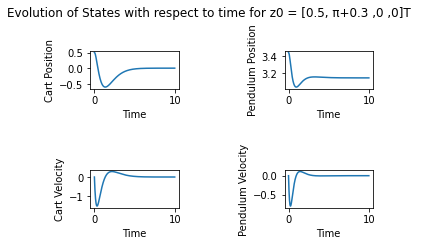

In [3]:
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
fig, axs = plt.subplots(2,2)
fig.suptitle('Evolution of States with respect to time for z0 = [0.5, π+0.3 ,0 ,0]T ')
axs[0,0].plot(t,z[0,:])
axs[0,0].set(xlabel='Time',ylabel='Cart Position')
axs[0,1].plot(t,z[1,:])
axs[0,1].set(xlabel='Time',ylabel='Pendulum Position')
axs[1,0].plot(t,z[2,:])
axs[1,0].set(xlabel='Time',ylabel='Cart Velocity')
axs[1,1].plot(t,z[3,:])
axs[1,1].set(xlabel='Time',ylabel='Pendulum Velocity')
fig.tight_layout(pad=5.0)

Text(0.5, 1.0, 'Evolution of Control Inputs with time z0 = [0.5, π+0.3 ,0 ,0]T')

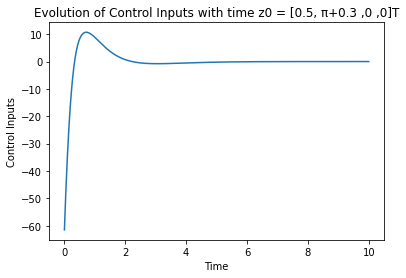

In [4]:
time = np.linspace(0,cart.dt*(horizon_length),horizon_length)
plt.plot(time,u[0,:])  
plt.xlabel('Time')
plt.ylabel('Control Inputs')
plt.title('Evolution of Control Inputs with time z0 = [0.5, π+0.3 ,0 ,0]T') 

In [5]:
animate_cart_pole(z, cart.dt)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAApS21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAu3ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qYXVPnJ+tJNi6sNAAo/0dD1q/R53JZS03FLu+ZzcmnznRGlJq7ZF2bRuikH6jqE4WNRJX
aXkfIby8uo+igFiQgnZewtBBTczwleW7j/O78VOPb7YOODAnEjewNVsrAcA5lzSZ4Z54TEzxQS/Z
P1rAWgekASySnIE2y99z/xGk+f5SZjb6B1mT8KctIjL6kCKXqBaLRPXuosngtvw60qO6RQngImOs
QrQCMEZZbj5leP+Re9ATC9dSS8fbtA9mbVgi4CwUIMJri0K1FE9z0fNKS2tmgfFTqTYbBvc/V/ca
BC5EEHpXKxFCVzn+L+ttJOBLNawqMxORkQeFJ7ZwOdmbyTlzhD2GOIrf+UKlEELX4GcTkTc0Eyvc
ltjTM5BmLhkXU9Zo7g9TSpDnmbV2kFmzzSKKOFa+TLdFUNJLmjQrGqMt8ZnyHMBWj///g5s5tmwE
W7Q+AaemVLqQIp/tlFkbuObafg1q2odCkmVJwT/fdaNP0QfLxAx8T9/6P7Ic/z+jVGOYXSYJ0eUw
Rv8Yumdj5dq64cl2dCM4MpUVVRJW3w6R4JpXCGUXVmsLpRk16UXbQq1fK3lPPalWGidhVSqF63yX
AgPnnJeuFkmzjMck1+8OWstNuOPoPfNkje95fu1BWod51Jl9fOGXIfzBGz3u8HeDcQ+G/Sb4UqCO
Ck6kAXKpXoaTY9G8ODfYXl3BJQ0n7ijBzxC5VbndRfAl+R7F6EHpRxwoUNByhJKyP7yr1rMtOePP
Y39fw8Kd3cda4tyrNbwJN/MZaCmjFFP1bN4X092H1aSlvfyPIe9hhYBNL48wbQ+OCyKUPZ0Asq2s
wvlHBulXApk/lMCMfQzB6ujdleBAyTXTEhlYLC8q3y8JmcH4P91bnAxOLTmgyh3+znfJ48zllDOZ
uoTnC9pS4Cb03WA523FdbpfoXAvzzJHOM/Lh6qM5zb9fAH+NGdWFe7RQHNaodD17VMDeY6SQgG4M
qGZ90K9stBR4mn8L/HAHY4474kEX57tkaJA/Az1cqgH282mtfV7Q8YJaMJUi97/sLXi6cXxGxhps
0hPT7u4h0PtNIM9Vimkp835U4vYQwpALGnMSHpt7TlDDExmXzsLFI44ob1KSm3XkfbH3GhU0ChDt
cY1rRjAOdZUUuPU/Kvmn3kX0kpKM4vEKSj8P+VTGnmY9WItd7B76ewNUZB9AHfGMjgpAOQIxE5HX
fllQQv1EUR5UY0ChLYX3/8iOTilO9g4Q2wR/809eWTIlGDiVG2zyC+I5Edww5gf1Vm+twFJcNVPr
pJssxjachluP6KDsv1eLPBPYrHBFsTNL3H9TQjjLQNII9IAA9bWN5u8qzw/pao6+Bk84T94Wm5c0
3TXGnB+2poTHfUKYZXEOjgXm/XgaFoQbmlGg2+BtCGrRsWPit4Lhz+C99ymu/RM6XTKb0o9++WN7
/b4Br4hOWR7+eg6r5bpTitYecVEFmIg8hcw17b//Nm8gKIGn/3NWbmu+M4PUZJadq3E1O191iqgN
ruUZKVFCuBxy7UCWgw59KXMoG9MPDj4RKibMuzdaQZPMJvwGb6KYQsi+hxW5C7a2DvB+Tl+LcZiu
f5T3cWKQJrE6twJ+9p6kA32e9DkU1oC8oxf4P2/HuCKjbrWO1XUtP+x1zs00C0WzaDr1iemc03nj
P+0Gv0J1Wkp7NHNrKRGRGhAtb3EkFMvwmg8AvmZgqPFEmY9+z5dZXl0mRLZRkwUzzuWuYT5vjCwt
V6TEA4PQ62KfH1S2pRxNbZLwTxsgVL2WUaTB8mXmfBukN7sVXqI//Pu5KImVwiKDV8lVb6Rgfz6d
mJx8tlHAROSJ+FStZtnBV2qBquS+PAWl33qedmQANCX0Us42gAL/byxQVG2ihdIANM6bsRnSBj7c
QEfknpmW5Z9zEDs+uTkkmyR9dQCdJ5od3jKDPTlKVerbRTSzKj7imeoLkVW4H4vTQZcMnH8dF+R5
x3U00KdPl+EPTnsSvsYd3wLarJJkA+KqF2Fx1r5U/csQIfLVifvlikYB4f466kijxRMkQTiKlHQL
lUsXTvmKbDpQfrF2GRAOI5b4pi1gwJ5rJ+TWuq1j2ZuiG/KgRS05XyVBe54GzNfmgA3Q88BG68+o
DWFl1LjZVjq4uP9j80aUK0YCyOAhp4CJ7Cn2U/T7NJsRJV+PWGROAH/DJBVZgyOIcb1xo+E+zmvQ
T2abDEeqit1PTxzBDC7rOT+m4e3ryYShWohnyPCURln/9L4AZc+3nIG5CYn06BdsuhYJRSUi6jV2
wdGs47KLItP51FDnSdMASFDNHczvve9NkA03jftp/rHwuIFkEb2q1vuzMzcucYeK42IHD27wE2z6
w2X3+K22Knm/TWTxdJu0jcOD//+xUqMsyltwHNCkpweLx6RZEAAOWSfLmC9Wfj3ZFPTAkK+nJV8f
RrkDOo65mQlTwrsBgV/aFmqs98BnSEFLj29sr/zsVfa0oAVrwxcBAFTBczpSYsm4Uyw2f2nb2Ugx
d+CodvuJABmLHIWenbOsSIHIc+simyJ2kleq8VSE4ysO6Bxqd0DxujbA87PjRq3TpnzzOlu/nlZE
9ZKHqWffMaLlTcZeNJoOQpPUo1Zm/D160g52hq7PQUzggYIdKVTolo2vhcobxJgUdO4G3zDT8USl
PkDgEFopmvFer5/d+BS04K+1oIzMw6sYSecofRQZ+ZVCCF27jDj6N+l+8uK1U3//xq3lmOBRIjiq
Q6o+Lj4uR40r1//bs38nNc0OcuiKcS2lnn/W0VPNR+KYOP08lz6TSbJ+7Zb9mxFK65ePu6QzRqzr
fj2fJTvY8/BDcDxL8qj9q